<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/04_action_recognition_STA-GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#STA-GCNによる動作認識

---



#Spatial Temporal Attention GCN (STA-GCN)

---



STA-GCNは関節の重要度と関節間の関係性を考慮した,骨格データからの動作認識手法です.  
Attention Branch NetworksのGCNへの応用手法です.

Attention Branchによって, 関節の重要度を表現するAttention nodeと  
動作特有の関節の関係性を表現するAttention edgeを獲得します.

- Attention node　　
  
  Attention nodeはフレーム$\times$関節の2次元マップで表現されます.  
  獲得したAttention nodeはAttention機構へ応用します.

- Attention edge

  Attention edgeは関節数$\times$関節数の隣接行列です.  
  獲得したAttention edgeはPerception branchに受け渡し, Perception branchでは骨格パターンとAttention edgeの2つのグラフ構造で畳み込みます.

<!-- 
<img src='https://drive.google.com/uc?id=1acyfT04LD2v8H5_HuYvLVSabTFsYdIky' width=50%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/04_sta_gcn.png?raw=true' width=50%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/04_sta_gcn.png?raw=true' width=50%>


# 実装前の準備

---



- 必要なモジュールのインポート

In [ ]:
import numpy as np
import IPython
from IPython import display
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import torch
import torch.nn as nn
import torch.nn.functional as F

- GPUの確認

In [ ]:
print('Use CUDA:', torch.cuda.is_available())

Use CUDA: True


シード値固定

In [ ]:
seed = 123
# Numpy
np.random.seed(seed)
# Pytorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

- データセットのダウンロード（前回と同じデータセット）

注: このデータセットは[NTU-RGB+Dデータセット](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Shahroudy_NTU_RGBD_A_CVPR_2016_paper.pdf)を利用して作成しました.  
Portions of the research used the NTU RGB+D Action Recognition Dataset made available by the ROSE Lab at the Nanyang Technological University, Singapore.

In [ ]:
!wget -q http://mprg.cs.chubu.ac.jp/~itaya/share/mprg_colab/NTU-RGBD_data/data.zip
!unzip -q -o data.zip

- データを読み込むための関数（前回と同様）

In [ ]:
class Feeder(torch.utils.data.Dataset):
  def __init__(self, data_path, label_path):
      super().__init__()
      self.label = np.load(label_path)
      self.data = np.load(data_path)

  def __len__(self):
      return len(self.label)

  def __iter__(self):
      return self

  def __getitem__(self, index):
      data = np.array(self.data[index])
      label = self.label[index]

      return data, label

- グラフを作る関数（前回と同様）

In [ ]:
class Graph():
  def __init__(self, hop_size=2):
    self.get_edge()
    self.hop_size = hop_size 
    self.hop_dis = self.get_hop_distance(self.num_node, self.edge, hop_size=hop_size)
    self.get_adjacency() 

  def __str__(self):
    return self.A

  def get_edge(self):
    self.num_node = 25
    self_link = [(i, i) for i in range(self.num_node)] # ループ
    neighbor_base = [(1, 2), (2, 21), (3, 21), (4, 3), (5, 21),
                      (6, 5), (7, 6), (8, 7), (9, 21), (10, 9),
                      (11, 10), (12, 11), (13, 1), (14, 13), (15, 14),
                      (16, 15), (17, 1), (18, 17), (19, 18), (20, 19),
                      (22, 23), (23, 8), (24, 25), (25, 12)]
    neighbor_link = [(i - 1, j - 1) for (i, j) in neighbor_base]
    self.edge = self_link + neighbor_link

  def get_adjacency(self):
    valid_hop = range(0, self.hop_size + 1, 1)
    adjacency = np.zeros((self.num_node, self.num_node))
    for hop in valid_hop:
        adjacency[self.hop_dis == hop] = 1
    normalize_adjacency = self.normalize_digraph(adjacency)
    A = np.zeros((len(valid_hop), self.num_node, self.num_node))
    for i, hop in enumerate(valid_hop):
        A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis == hop]
    self.A = A

  def get_hop_distance(self, num_node, edge, hop_size):
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(hop_size + 1)]
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(hop_size, -1, -1):
        hop_dis[arrive_mat[d]] = d
    return hop_dis

  def normalize_digraph(self, A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-1)
    DAD = np.dot(A, Dn)
    return DAD

# STA-GCNの実装

---



STA-GCNを実装します. ７つのclassを使います.
 - S_GC：空間グラフ畳み込み（前回と同様）
 - S_GC_att_edge：att_edgeと空間グラフの2つで畳み込みます．perception branchで使われます.
 - STGC_Block：空間グラフの呼び出しと時間グラフ畳み込みを行うclassです. 前回より残差処理が増えています.
 - FeatureExtractor：STGC_blockを複数呼び出します.
 - AttentionBranch：STGC_blockを複数呼び出し. Attention nodeとAttention edgeを作成します.
 - PerceptionBranch：STGC_blockを複数呼び出し.STGC_block内でS_GC_att_edgeを呼び出すように条件分岐しています.
 - STA-GCN：FeatureExtractor,　AttentionBranch,　PerceptionBranchを呼び出します.

### S_GG：空間グラフ畳み込み

空間グラフ${\bf A}^{skel}$の畳み込み式を定義します. 変数が違いますが, ST-GCNと同様です.  

\begin{equation}
{\bf X}^{skel}_{out}=\sum^{Q}_{q}{\bf M}^{skel}_{q}\circ{\bf\hat A}^{skel}_{q}{\bf X}_{in}{\bf W}^{skel}_{q}
\end{equation}

$Q$が隣接行列の数, ${\bf M}$はエッジの重み, $\circ$は要素積です.  
式が冗長になるのを防ぐため, ${\bf\tilde D}^{-\frac{1}{2}}_q{\bf\tilde A}^{skel}_q{\bf\tilde D}^{-\frac{1}{2}}_q={\bf\hat A}^{skel}_q$と定義しています.

In [ ]:
class S_GC(nn.Module):
  def __init__(self, in_channels, out_channels, s_kernel_size):
    super(S_GC, self).__init__()
    self.s_kernel_size = s_kernel_size
    self.conv = nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels * s_kernel_size,
                          kernel_size=1)
    
  def forward(self, x, A, att_edge=None):
    x = self.conv(x)
    n, kc, t, v = x.size()
    x = x.view(n, self.s_kernel_size, kc//self.s_kernel_size, t, v)
    x = torch.einsum('nkctv,kvw->nctw', (x, A))
    return x.contiguous()

### S_GG_att_edge：空間グラフとAttention edgeの畳み込み
Perception branchでは空間グラフとAttention edgeの2つのグラフ構造で畳み込むため，そのための関数を作ります.  
Attention edge${\bf A}^{att}$のグラフ畳み込み式を定義します.  

\begin{equation}
{\bf X}^{att}_{out}=\sum^{K}_{k}{\bf\hat A}^{att}_{k}{\bf X}_{in}{\bf W}^{att}_{k}
\end{equation}　　

空間グラフとほぼ同様です.  
$K$が動作ごとのAttention edgeの数，　${\bf\tilde D}^{-\frac{1}{2}}_k{\bf\tilde A}^{att}_k{\bf\tilde D}^{-\frac{1}{2}}_k={\bf\hat A}^{att}_k$と定義しています.





空間グラフ畳み込みの出力${\bf X}^{skel}_{out}$と,Attention edgeの畳み込みの出力${\bf X}^{att}_{out}$を足し合わせます.

\begin{equation}
{\bf X}_{out}={\bf X}^{skel}_{out}+{\bf X}^{att}_{out}
\end{equation}

In [ ]:
class S_GC_att_edge(nn.Module):
  def __init__(self, in_channels, out_channels, s_kernel_size, num_att_edge):
    super(S_GC_att_edge, self).__init__()
    self.num_att_edge = num_att_edge
    self.s_kernel_size = s_kernel_size + num_att_edge
    self.conv = nn.Conv2d(in_channels=in_channels,
                           out_channels=out_channels * self.s_kernel_size,
                           kernel_size=1)

  def forward(self, x, A, att_edge):
    x = self.conv(x)
    n, kc, t, v = x.size()
    x = x.view(n, self.s_kernel_size, kc//self.s_kernel_size, t, v)
    x1 = x[:, :self.s_kernel_size-self.num_att_edge, :, :, :]
    x2 = x[:, -self.num_att_edge:, :, :, :]
    x1 = torch.einsum('nkctv,kvw->nctw', (x1, A))
    x2 = torch.einsum('nkctv,nkvw->nctw', (x2, att_edge))
    x_sum = x1 + x2

    return x_sum

### STGC_Block

空間グラフ畳み込みや，時間グラフを繰り返すのでSTGB-Blockとして関数化しておきます.  
また， GCNの分野でも深層化の進みに伴い, 残差処理が使われることも多くなりました.  
STA-GCNでも残差処理を取り入れています.

<!--
<img src='https://drive.google.com/uc?id=1uSkwOW8V-KFBNmJBvOMgKShqaMTLeFzb' width=40%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/04_stgc_block.png?raw=true' width=40%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/04_stgc_block.png?raw=true' width=40%>

In [ ]:
class STGC_Block(nn.Module):
  def __init__(self, in_channels, out_channels, stride, s_kernel_size, t_kernel_size, dropout, A_size, num_att_edge=0, use_att_edge=False):
    super(STGC_Block, self).__init__()
    # 空間グラフ畳み込み attention edgeありかなしか
    if not use_att_edge:
      self.sgc = S_GC(in_channels=in_channels,
                       out_channels=out_channels,
                       s_kernel_size=s_kernel_size)
    else:
      self.sgc = S_GC_att_edge(in_channels=in_channels,
                                 out_channels=out_channels,
                                 s_kernel_size=s_kernel_size,
                                 num_att_edge=num_att_edge)

    # Learnable weight matrix M エッジに重みを与えます. どのエッジが重要かを学習します.
    self.M = nn.Parameter(torch.ones(A_size))
    
    # 時間グラフ畳み込み
    self.tgc = nn.Sequential(nn.BatchNorm2d(out_channels),
                            nn.ReLU(),
                            nn.Conv2d(out_channels,
                                      out_channels,
                                      (t_kernel_size, 1),
                                      (stride, 1),
                                      ((t_kernel_size - 1) // 2, 0)),
                            nn.BatchNorm2d(out_channels),
                            nn.Dropout(dropout),
                            nn.ReLU()) 
    
    # 残差処理
    if(in_channels == out_channels) and (stride == 1):
      self.residual = lambda x: x
    else:
      self.residual = nn.Sequential(nn.Conv2d(in_channels,
                                              out_channels,
                                              kernel_size=1,
                                              stride=(stride, 1)),
                                    nn.BatchNorm2d(out_channels))

  def forward(self, x, A, att_edge):
    x = self.tgc(self.sgc(x, A * self.M, att_edge)) + self.residual(x)
    return x

### Feature extractor
骨格データを入力として, 複数のSTGC-blockで特徴を抽出します.  
今回は小さなデータセットを使うので, STGC-block $\times 3$として実装します.

<!--
<img src='https://drive.google.com/uc?id=1EWtkDVeHqYdMOs6pEpx-PkPoe1rQi_ji' width=30%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/04_feature_extractor.png?raw=true' width=30%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/04_feature_extractor.png?raw=true' width=30%>


In [ ]:
class FeatureExtractor(nn.Module):
  def __init__(self, config, s_kernel_size, t_kernel_size, dropout, A_size):
    super(FeatureExtractor, self).__init__()
    # Batch Normalization
    self.bn = nn.BatchNorm1d(config[0][0] * A_size[2])

    # STGC-Block config
    kwargs = dict(s_kernel_size=s_kernel_size,
                  t_kernel_size=t_kernel_size,
                  dropout=dropout,
                  A_size=A_size)
    self.stgc_block1 = STGC_Block(config[0][0], config[0][1], config[0][2], **kwargs)
    self.stgc_block2 = STGC_Block(config[1][0], config[1][1], config[1][2], **kwargs)
    self.stgc_block3 = STGC_Block(config[2][0], config[2][1], config[2][2], **kwargs)

  def forward(self, x, A):
    # Batch Normalization
    N, C, T, V = x.size() # batch, channel, frame, node
    x = x.permute(0, 3, 1, 2).contiguous().view(N, V * C, T)
    x = self.bn(x)
    x = x.view(N, V, C, T).permute(0, 2, 3, 1).contiguous()
    # STGC Blocks
    x = self.stgc_block1(x, A, None)
    x = self.stgc_block2(x, A, None)
    x = self.stgc_block3(x, A, None)
    return x

### Attention branch
３つのSTGC-Blockの出力値をもとに, Attention edgeとAttention nodeを生成します.  
図を見ながら, コードを見れば理解しやすいと思います

<!--
<img src='https://drive.google.com/uc?id=1vFth2RjFeGYXRsfPwgZa-P6R4uvtI5B5' width=40%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/04_attention_branch.png?raw=true' width=40%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/04_attention_branch.png?raw=true' width=40%>


In [ ]:
class AttentionBranch(nn.Module):
  def __init__(self, config, num_classes, num_att_edge, s_kernel_size, t_kernel_size, dropout, A_size):
    super(AttentionBranch, self).__init__()
    # STGC-Block config
    kwargs = dict(s_kernel_size=s_kernel_size,
                  t_kernel_size=t_kernel_size,
                  dropout=dropout,
                  A_size=A_size)
    self.stgc_block1 = STGC_Block(config[0][0], config[0][1], config[0][2], **kwargs)
    self.stgc_block2 = STGC_Block(config[1][0], config[1][1], config[1][2], **kwargs)
    self.stgc_block3 = STGC_Block(config[2][0], config[2][1], config[2][2], **kwargs)

    # Prediction
    self.fc = nn.Conv2d(config[-1][1], num_classes, kernel_size=1, padding=0)

    # Attention
    self.att_bn = nn.BatchNorm2d(config[-1][1])
    self.att_conv = nn.Conv2d(config[-1][1], num_classes, kernel_size=1, padding=0, stride=1, bias=False)

    # Attention node
    self.att_node_conv = nn.Conv2d(num_classes, 1, kernel_size=1, padding=0, stride=1, bias=False)
    self.att_node_bn = nn.BatchNorm2d(1)
    self.sigmoid = nn.Sigmoid()

    # Attention edge
    self.num_att_edge = num_att_edge
    self.att_edge_conv = nn.Conv2d(num_classes, num_att_edge * A_size[2], kernel_size=1, padding=0, stride=1, bias=False)
    self.att_edge_bn = nn.BatchNorm2d(num_att_edge * A_size[2])
    self.tanh = nn.Tanh()
    self.relu = nn.ReLU()

  def forward(self, x, A):
    N, c, T, V = x.size()

    # STGC Block
    x = self.stgc_block1(x, A, None)
    x = self.stgc_block2(x, A, None)
    x = self.stgc_block3(x, A, None)

    # Prediction
    x_out = F.avg_pool2d(x, x.size()[2:])
    x_out = x_out.view(N, -1, 1, 1)
    x_out = self.fc(x_out)
    output = x_out.view(x_out.size(0), -1)

    # Attention
    x_att = self.att_bn(x)
    x_att = self.att_conv(x_att)

    # Attention node
    x_node = self.att_node_conv(x_att)
    x_node = self.att_node_bn(x_node)
    x_node = F.interpolate(x_node, size=(T, V))
    att_node = self.sigmoid(x_node)

    # Attention edge
    x_edge = F.avg_pool2d(x_att, (x_att.size()[2], 1))
    x_edge = self.att_edge_conv(x_edge)
    x_edge = self.att_edge_bn(x_edge)
    x_edge = x_edge.view(N, self.num_att_edge, V, V)
    x_edge = self.tanh(x_edge)
    att_edge = self.relu(x_edge)

    return output, att_node, att_edge 

### Perception branch
Perception branchでは，Attention edgeも使って畳み込みます.  
STGC_blockに'use_att_edge=True'を与えれば，切り替わります.

<!--
<img src='https://drive.google.com/uc?id=1InAhogQTFboGULh3PR96x5EMgrHiAir9' width=40%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/04_perception_branch.png?raw=true' width=40%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/04_perception_branch.png?raw=true' width=40%>

In [ ]:
class PerceptionBranch(nn.Module):
  def __init__(self, config, num_classes, num_att_edge, s_kernel_size, t_kernel_size, dropout, A_size, use_att_edge=True):
    super(PerceptionBranch, self).__init__()
    # STGC-Block config
    kwargs = dict(s_kernel_size=s_kernel_size,
                  t_kernel_size=t_kernel_size,
                  dropout=dropout,
                  A_size=A_size,
                  num_att_edge=num_att_edge,
                  use_att_edge=use_att_edge)
    self.stgc_block1 = STGC_Block(config[0][0], config[0][1], config[0][2], **kwargs)
    self.stgc_block2 = STGC_Block(config[1][0], config[1][1], config[1][2], **kwargs)
    self.stgc_block3 = STGC_Block(config[2][0], config[2][1], config[2][2], **kwargs)

    # Prediction
    self.fc = nn.Conv2d(config[-1][1], num_classes, kernel_size=1, padding=0)

  def forward(self, x, A, att_edge):
    N, c, T, V = x.size()
    # STGC Block
    x = self.stgc_block1(x, A, att_edge)
    x = self.stgc_block2(x, A, att_edge)
    x = self.stgc_block3(x, A, att_edge)

    # Prediction
    x = F.avg_pool2d(x, x.size()[2:])
    x = x.view(N, -1, 1, 1)
    x = self.fc(x)
    output = x.view(x.size(0), -1)

    return output

### STA-GCN

FeatureExtractor,AttentionBranch,PercepitonBranchを呼び出して, ネットワークを完成させます.

In [ ]:
class STA_GCN(nn.Module):
  def __init__(self, num_classes, in_channels, t_kernel_size, hop_size, num_att_edge, dropout=0.5):
    super(STA_GCN, self).__init__()

    # Graph
    graph = Graph(hop_size)
    A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False)
    self.register_buffer('A', A)

    kwargs = dict(s_kernel_size=A.size(0),
                   t_kernel_size=t_kernel_size,
                   dropout=dropout,
                   A_size=A.size())

    # Feature extractor
    f_config = [[in_channels, 32, 1], [32, 32, 1], [32, 32, 1]]
    self.feature_extractor = FeatureExtractor(f_config, **kwargs)

    # Attention branch
    a_config = [[32, 64, 2], [64, 64, 1], [64, 64, 1]]
    self.attention_branch = AttentionBranch(a_config, num_classes, num_att_edge, **kwargs)

    # Perception branch
    p_config = [[32, 64, 2], [64, 64, 1], [64, 64, 1]]
    self.perception_branch = PerceptionBranch(p_config, num_classes, num_att_edge, **kwargs)

  def forward(self, x):
    # Feature extractor
    feature = self.feature_extractor(x, self.A)

    # Attention branch
    output_ab, att_node, att_edge = self.attention_branch(feature, self.A)

    # Attention mechanism
    att_x = feature * att_node
    
    # Perception branch
    output_pb = self.perception_branch(att_x, self.A, att_edge)

    return output_ab, output_pb, att_node, att_edge

#学習

---



In [ ]:
NUM_EPOCH = 100
BATCH_SIZE = 64
HOP_SIZE = 2
NUM_ATT_EDGE = 2 # 動作ごとのattention edgeの生成数

# モデルを作成
model = STA_GCN(num_classes=10, 
                  in_channels=3,
                  t_kernel_size=9, # 時間グラフ畳み込みのカーネルサイズ (t_kernel_size × 1)
                  hop_size=HOP_SIZE,
                  num_att_edge=NUM_ATT_EDGE).cuda()

# オプティマイザ
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 誤差関数
criterion = torch.nn.CrossEntropyLoss()

# データセットの用意
data_loader = dict()
data_loader['train'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/train_data.npy', label_path='data/train_label.npy'), batch_size=BATCH_SIZE, shuffle=True,)
data_loader['test'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/test_data.npy', label_path='data/test_label.npy'), batch_size=BATCH_SIZE, shuffle=False)

# モデルを学習モードに変更
model.train()

# 学習開始
for epoch in range(1, NUM_EPOCH+1):
  correct_pb = 0
  sum_loss = 0
  for batch_idx, (data, label) in enumerate(data_loader['train']):
    data = data.cuda()
    label = label.cuda()

    output_ab, output_pb, _, _ = model(data)

    loss = criterion(output_ab, label) + criterion(output_pb, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    sum_loss += loss.item()
    _, predict = torch.max(output_pb.data, 1)
    correct_pb += (predict == label).sum().item()

  print('# Epoch: {} | Loss: {:.4f} | Accuracy PB: {:.3f}[%]'.format(epoch, sum_loss/len(data_loader['train'].dataset), (100. * correct_pb / len(data_loader['train'].dataset))))

STA_GCN(
  (feature_extractor): FeatureExtractor(
    (bn): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (stgc_block1): STGC_Block(
      (sgc): S_GC(
        (conv): Conv2d(3, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (tgc): Sequential(
        (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
        (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Dropout(p=0.5, inplace=False)
        (5): ReLU()
      )
      (residual): Sequential(
        (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (stgc_block2): STGC_Block(
      (sgc): S_GC(
        (conv): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (tgc): Sequential(
        

# Epoch: 1 | Loss: 0.0692 | Accuracy PB: 22.800[%]
# Epoch: 2 | Loss: 0.0611 | Accuracy PB: 31.450[%]
# Epoch: 3 | Loss: 0.0531 | Accuracy PB: 41.150[%]
# Epoch: 4 | Loss: 0.0481 | Accuracy PB: 48.850[%]
# Epoch: 5 | Loss: 0.0421 | Accuracy PB: 58.350[%]
# Epoch: 6 | Loss: 0.0417 | Accuracy PB: 58.400[%]
# Epoch: 7 | Loss: 0.0333 | Accuracy PB: 67.400[%]
# Epoch: 8 | Loss: 0.0281 | Accuracy PB: 72.300[%]
# Epoch: 9 | Loss: 0.0249 | Accuracy PB: 76.300[%]
# Epoch: 10 | Loss: 0.0231 | Accuracy PB: 78.150[%]
# Epoch: 11 | Loss: 0.0218 | Accuracy PB: 80.150[%]
# Epoch: 12 | Loss: 0.0204 | Accuracy PB: 81.250[%]
# Epoch: 13 | Loss: 0.0185 | Accuracy PB: 82.650[%]
# Epoch: 14 | Loss: 0.0176 | Accuracy PB: 82.500[%]
# Epoch: 15 | Loss: 0.0174 | Accuracy PB: 84.300[%]
# Epoch: 16 | Loss: 0.0185 | Accuracy PB: 82.500[%]
# Epoch: 17 | Loss: 0.0173 | Accuracy PB: 82.550[%]
# Epoch: 18 | Loss: 0.0149 | Accuracy PB: 85.900[%]
# Epoch: 19 | Loss: 0.0148 | Accuracy PB: 86.700[%]
# Epoch: 20 | Loss: 0

# 評価

---



STA_GCN(
  (feature_extractor): FeatureExtractor(
    (bn): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (stgc_block1): STGC_Block(
      (sgc): S_GC(
        (conv): Conv2d(3, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (tgc): Sequential(
        (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
        (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Dropout(p=0.5, inplace=False)
        (5): ReLU()
      )
      (residual): Sequential(
        (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (stgc_block2): STGC_Block(
      (sgc): S_GC(
        (conv): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (tgc): Sequential(
        

Text(0.5, 1.0, 'Confusion matrix')

([<matplotlib.axis.XTick at 0x7fa738550390>,
 [Text(-2.0, 0, 'drink'),
  Text(0.0, 0, 'throw'),
  Text(2.0, 0, 'sit down'),
  Text(4.0, 0, 'stand up'),
  Text(6.0, 0, 'clapping'),
  Text(8.0, 0, 'hand waving'),
  Text(10.0, 0, 'kicking'),
  Text(0, 0, 'jump up'),
  Text(0, 0, 'salute'),
  Text(0, 0, 'falling down')])

([<matplotlib.axis.YTick at 0x7fa738560690>,
 [Text(0, -2.0, 'drink'),
  Text(0, 0.0, 'throw'),
  Text(0, 2.0, 'sit down'),
  Text(0, 4.0, 'stand up'),
  Text(0, 6.0, 'clapping'),
  Text(0, 8.0, 'hand waving'),
  Text(0, 10.0, 'kicking'),
  Text(0, 0, 'jump up'),
  Text(0, 0, 'salute'),
  Text(0, 0, 'falling down')])

Text(95.305, 0.5, 'True')

Text(0.5, 15.0, 'Predicted')

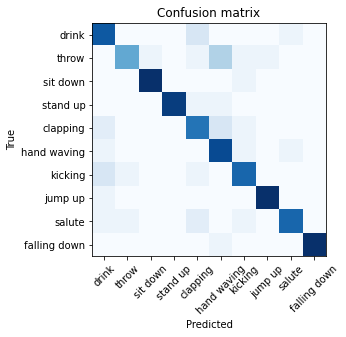

# Test Accuracy PB: 81.000[%]


In [ ]:
# モデルを評価モードに変更
model.eval()

correct_pb = 0
confusion_matrix = np.zeros((10, 10))
with torch.no_grad():
  for batch_idx, (data, label) in enumerate(data_loader['test']):
    data = data.cuda()
    label = label.cuda()

    output_ab, output_pb, _, _ = model(data)

    _, predict = torch.max(output_pb.data, 1)
    correct_pb += (predict == label).sum().item()

    for l, p in zip(label.view(-1), predict.view(-1)):
      confusion_matrix[l.long(), p.long()] += 1

len_cm = len(confusion_matrix)
for i in range(len_cm):
    sum_cm = np.sum(confusion_matrix[i])
    for j in range(len_cm):
        confusion_matrix[i][j] = 100 * (confusion_matrix[i][j] / sum_cm)

classes = ['drink', 'throw', 'sit down', 'stand up', 'clapping', 'hand waving', 'kicking', 'jump up', 'salute', 'falling down']
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.tight_layout()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

print('# Test Accuracy PB: {:.3f}[%]'.format((100. * correct_pb / len(data_loader['test'].dataset))))

# Attentionの可視化


---



可視化に使う関数群

In [ ]:
def ntu_config():
  num_node = 25
  small_node_list = [8, 12, 22, 23, 24, 25]
  adjacency_matrix = [[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                      [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                      [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                      [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
                      [0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
                      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]]
  return num_node, small_node_list, adjacency_matrix

action_list = ['飲む','投げる','座る','立ち上がる','拍手','手を振る','蹴る','ジャンプ','敬礼','転倒',]
def to_label(index):
  return action_list[index]

def build_K(M, num_edge, num_node): #重みの大きいエッジのみ(30本)を選択
  A = np.identity(num_node)
  for i in range(num_node):
      M[i][i] = -100
  for i in range(num_edge):
      leave_index = np.argmax(M)
      x = leave_index % num_node
      y = leave_index // num_node
      if x == y:
          raise ValueError
      else:
          A[y][x] = A[x][y] = 1
          M[y][x] = M[x][y] = -100
  return A

def plot_map_graph(map, A, data, num_node, small_node_list, adjacency_matrix, cmap, filename, node_size=15, small_node_size=10):
  img = Image.new("RGB", (600, 900), (255, 255, 255))
  draw = ImageDraw.Draw(img)
  gray = (130, 130, 130)
  
  # Inversion and Expansion
  data[0] = data[0] * -400
  data[1] = data[1] * -400

  # node list
  node_list = []
  x_decay = 300 - data[0][0]
  y_decay = 450 - data[1][0]
  for i in range(num_node):
      node_list.append([data[0][i] + x_decay, data[1][i] + y_decay])
  
  # gray edge
  for x in range(num_node):
      for y in range(num_node):
          if 1 == adjacency_matrix[x][y]:
              s_x = node_list[x][0]
              s_y = node_list[x][1]
              f_x = node_list[y][0]
              f_y = node_list[y][1]
              draw.line((s_x, s_y, f_x, f_y), fill=gray, width=5)

  # plot edge
  red = (204, 0, 0)
  for y in range(num_node):
      for x in range(num_node):
          if A[y][x] == 1:
              s_x = node_list[x][0]
              s_y = node_list[x][1]
              f_x = node_list[y][0]
              f_y = node_list[y][1]
              draw.line((s_x, s_y, f_x, f_y), fill=red, width=3)

  # plot node
  for i, (x, y) in enumerate(node_list):
      col = cmap(map[i])
      color = (int(col[0] * 255), int(col[1] * 255), int(col[2] * 255))
      if i + 1 not in small_node_list:
          draw.ellipse(((x - node_size, y - node_size), (x + node_size, y + node_size)), outline=(255, 255, 255),
                        fill=color)
      else:
          draw.ellipse(((x - small_node_size, y - small_node_size), (x + small_node_size, y + small_node_size)),
                        outline=(255, 255, 255), fill=color)

  img.save(filename)

def plot_graph(att_node, att_edge, skeletons, num_att_edge, n_att_edge, num_edge=30):
  num_node, small_node_list, adjacency_matrix = ntu_config()
  cmap = plt.get_cmap('jet')

  # att node
  map = torch.squeeze(att_node).permute(1, 0).data.cpu().numpy()
  map = (map - map.min()) / (map.max() - map.min()) # torch.Size([25, 80])

  # att edge
  A_list = []
  for i in range(num_att_edge):
    A = build_K(att_edge[i], num_edge, num_node)
    A_list.append(A)

  #for i in range(num_att_edge):
  A = A_list[n_att_edge]
  p = 0
  for t in range(0, skeletons.shape[1], 2):
    filename = '{:03d}.png'.format(p)
    plot_map_graph(map[:, p], A, skeletons[:, t, :].copy(), num_node, small_node_list, adjacency_matrix, cmap, filename)
    p += 1


STA_GCN(
  (feature_extractor): FeatureExtractor(
    (bn): BatchNorm1d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (stgc_block1): STGC_Block(
      (sgc): S_GC(
        (conv): Conv2d(3, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (tgc): Sequential(
        (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(9, 1), stride=(1, 1), padding=(4, 0))
        (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Dropout(p=0.5, inplace=False)
        (5): ReLU()
      )
      (residual): Sequential(
        (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (stgc_block2): STGC_Block(
      (sgc): S_GC(
        (conv): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1))
      )
      (tgc): Sequential(
        

# Label: 投げる | Prediction 投げる


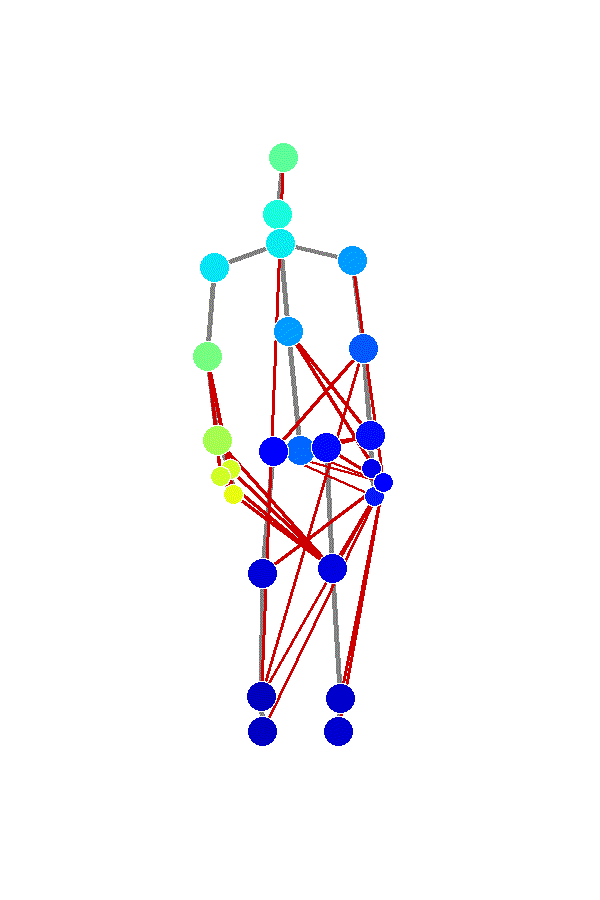

In [ ]:
DATA_INDEX = 22
# 0~19　　 : 飲む
# 20~39 : 投げる
# 40~59 : 座る
# 60~79 : 立ち上がる
# 80~99 : 拍手
# 100~119 : 手を振る
# 120~139 : 蹴る
# 140~159 : ジャンプ
# 160~179 : 敬礼
# 180~199 : 転倒

n_att_edge = 0 # 複数のAttention edgeを生成したので，何番目のAttention edgeを描画するか

feeder = Feeder(data_path='data/test_data.npy', label_path='data/test_label.npy')
model.eval()
with torch.no_grad():
  data, label = feeder[DATA_INDEX]
  data = torch.tensor(data).unsqueeze(0).cuda()
  output_ab, output_pb, att_node, att_edge = model(data)
  _, predict_pb = torch.max(output_pb.data, 1)
  print('# Label: {} | Prediction {}'.format(to_label(label), to_label(predict_pb.item())))

  # plot
  plot_graph(att_node[0], att_edge[0].cpu().numpy(), data[0].cpu().numpy(), NUM_ATT_EDGE, n_att_edge)

# 複数のpng画像からgif画像を生成
images = []
for i in range(40):
    filename = '{:03}.png'.format(i)
    img = Image.open(filename)
    images.append(img)
images[0].save('out.gif', save_all=True, append_images=images[1:], loop=0, duration=80)

# 表示
with open('out.gif','rb') as f:
  display.Image(data=f.read(), format='png')